# Machine learning for bike sharing

In [1]:
# Install the ucimlrepo package to easily import dataset
!pip install ucimlrepo 

# Install SHAP
!pip install shap --quiet

In [2]:
# Import packages
import pandas as pd
import numpy as np
import shap
shap.initjs()

/Users/kachiemenike/Documents/blue_yonder_bike_sharing/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load data

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
hourly_dataset  = fetch_ucirepo(id=275)
# access data (as pandas dataframes)
features = hourly_dataset.data.features

# Accessing the target feature

target = hourly_dataset.data.targets
target = target['cnt'].values
target


# Drop the date and instant columns
features = features.drop(['dteday'], axis=1)

In [4]:
# An overview of the data
features.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0


## 2. Data preprocessing

In [5]:
# An overview of the dataset
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 1.6 MB


In [6]:
features.shape

(17379, 12)

There are 12 columns and 17379 rows in the `features` dataframe.

In [7]:
# Identifying the numerical and categorical features
numerical_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']

#### Handling categorical variables:
In typical regression tasks, categorical variables are transformed into numerical representations, commonly through techniques like one-hot encoding or label encoding and ordinal encoding. However, in our hourly dataset, the categorical features have already been encoded in the preferred label encoding format, streamlining the preprocessing step for regression analysis.

#### Handling outliers and missing values:
Furthermore, it's crucial to detect and address outliers in the dataset, as they can substantially impact the performance of regression models. Fortunately, based on the summary statistics below, we don't have any outliers. This enables us to utilize the mean cross-validation scores for evaluation confidently. Additionally, there are no missing values in the given dataset.

In [8]:
features.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700


#### Feature scaling:

Standardizing or normalizing numerical features ensures they are on a similar scale. Fortunately, in our dataset `hourly_df`, the numerical features are already on a similar scale, so there's no need to apply the StandardScaler processor.

## 3. Model building:

Our aim is to select the most relevant model for the regression problem, ensuring accurate predictions and optimal performance. This involves thorough evaluation and comparison of various regression algorithms to identify the one that best fits our dataset and addresses the specific requirements of the task at hand.

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


#### Histogram gradient boosting
Next, we present a modified version of gradient boosting which uses a reduced number of splits when building the different trees. This algorithm is called "histogram gradient boosting" in scikit-learn.

Histogram-based gradient boosting offers faster training by precomputing histograms for feature values, reducing the computational cost of evaluating split points. They also use less memory by storing histograms instead of individual feature values, making them suitable for large datasets. Moreover, these techniques often lead to improved predictive performance, especially for datasets with many features or observations.

In [10]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error

histogram_gradient_boosting = HistGradientBoostingRegressor(random_state=42)
cv_results_hgbdt = cross_validate(
    histogram_gradient_boosting,
    X_train,
    y_train,
    scoring="neg_mean_absolute_error",
    n_jobs=2,
    cv=10
)
histogram_gradient_boosting.fit(X_train,y_train)
y_train_pred_hgb = histogram_gradient_boosting.predict(X_train)
print("Histogram Gradient Boosting")
train_mae = mean_absolute_error(y_train, y_train_pred_hgb)
print("Mean absolute error on Training Set:" f"{train_mae:.2f}")
print(
    "Mean absolute error via cross-validation: "
    f"{-cv_results_hgbdt['test_score'].mean():.2f} ± "
    f"{cv_results_hgbdt['test_score'].std():.2f}"
)
print(f"Average fit time: {cv_results_hgbdt['fit_time'].mean():.2f} seconds")
print(
    f"Average score time: {cv_results_hgbdt['score_time'].mean():.2f} seconds"
)

Histogram Gradient Boosting
Mean absolute error on Training Set:23.89
Mean absolute error via cross-validation: 26.19 ± 1.07
Average fit time: 1.69 seconds
Average score time: 0.01 seconds


The histogram Gradient Boosting Decision Tree model achieved a lower mean absolute error via cross-validation, indicating superior predictive accuracy compared to both previous configurations.


Therefore, based solely on the mean absolute error via cross-validation, the histogram Gradient Boosting Decision Tree model appears to be the best-performing model among the three. It captures the underlying patterns in the data more effectively, resulting in better predictive performance.

#### Hyperparameter tuning by randomized-search

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_distributions = {
    "max_iter": [3, 10, 30, 100, 300, 1000],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
}
search_cv = RandomizedSearchCV(
    HistGradientBoostingRegressor(random_state=42),
    param_distributions=param_distributions,
    scoring="neg_mean_absolute_error",
    n_iter=20,
    random_state=0,
    n_jobs=2,
)
search_cv.fit(X_train, y_train)


columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

,param_max_iter,param_max_leaf_nodes,param_learning_rate,mean_test_error,std_test_error
14,300,100,0.01864,25.348028,0.494867
6,300,20,0.047293,26.755207,0.664617
2,30,50,0.176656,27.990198,0.381232
13,300,10,0.297739,28.246224,1.150484
9,100,20,0.083745,28.964229,0.730469
19,100,10,0.215543,29.688705,0.541745
12,100,20,0.067503,30.362239,0.667848
16,300,5,0.05929,40.122075,0.741315
1,100,5,0.160519,40.446623,0.702101
18,10,5,0.248463,73.467776,1.278601


We can now estimate the generalization performance of the best model using the test set.

In [12]:
error = -search_cv.score(X_test, y_test)
print(f"On average, our histogram gradient boosting regressor makes an error of {error:.2f}")

On average, our histogram gradient boosting regressor makes an error of 24.42


The mean test score in the held-out test set is slightly better than the score of the best model.

In [13]:
# Obtain the best estimator from the search_cv
best_model = search_cv.best_estimator_

# Predict using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

#### Model Interpretability
Next, we will create an explainer object by providing a histogram gradient boosting regressor model, then calculate SHAP value using a testing set.

In [14]:
explainer = shap.Explainer(histogram_gradient_boosting)
shap_values = explainer.shap_values(X_test)

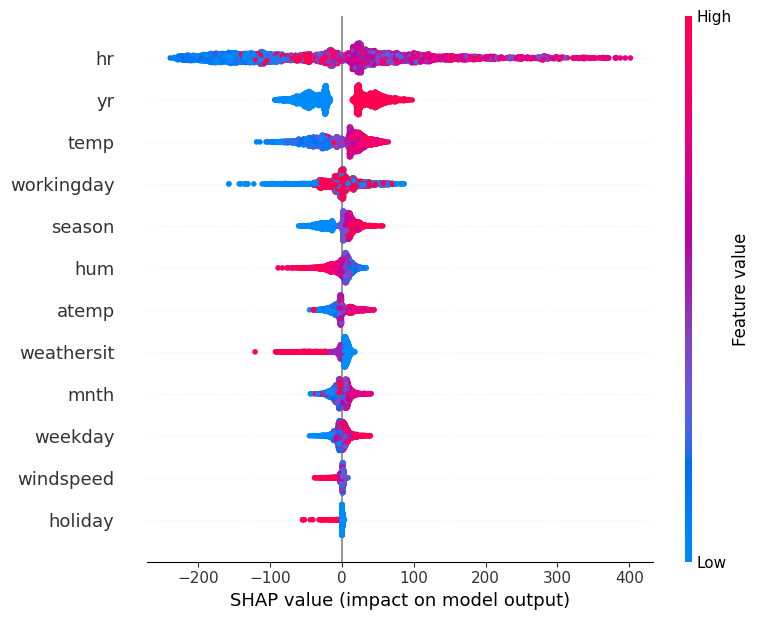

In [15]:
# Display the summary_plot using SHAP values and testing set.
shap.summary_plot(shap_values, X_test)

The summary plot shows the feature importance of each feature in the model. The results show that `hr`, `yr`, and `temp` play major roles in determining the results.

The color of each point on the graph represents the value of the corresponding feature, with red indicating high values and blue indicating low values.

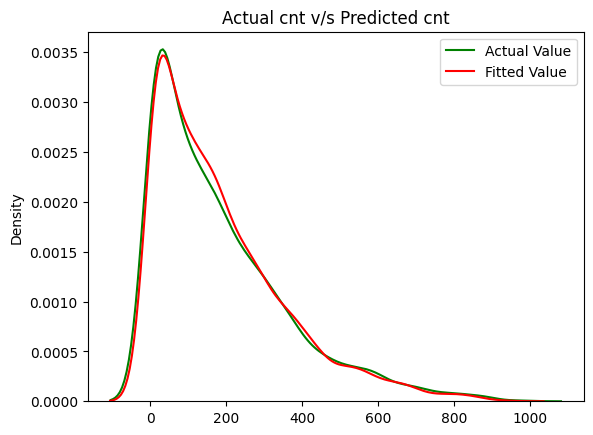

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.title("Actual cnt v/s Predicted cnt")
ax1 = sns.kdeplot(y_test, color="green", label="Actual Value")
sns.kdeplot(y_pred_test, color="red", label="Fitted Value", ax=ax1)
plt.legend()
plt.show()

The plot visually depicts how well our predictive model aligns with the actual values of bike rental counts. Having a close match between the actual and predicted distributions signifies a reliable predictive model, providing confidence in its ability to forecast bike rental demand accurately.

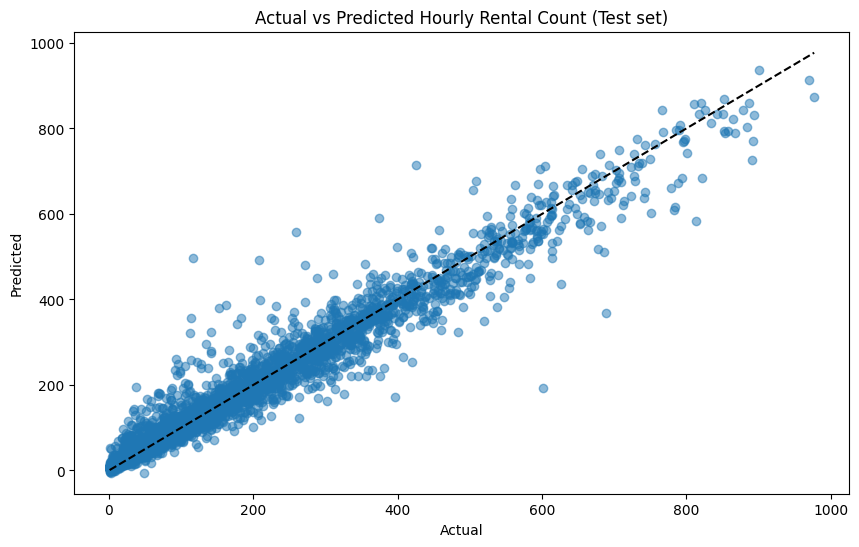

In [17]:
import matplotlib.pyplot as plt
# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k')
plt.title('Actual vs Predicted Hourly Rental Count (Test set)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

This scatter plot allows us to visually assess the relationship between the actual and predicted values of the target variable. Where points close to the diagonal line indicate accurate predictions, while deviations from the line suggest discrepancies between the actual and predicted value.